In [8]:
import csv
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os

from anytree import Node, RenderTree, Resolver, AnyNode, LevelOrderIter, PreOrderIter
from collections import defaultdict
from tqdm import tqdm_notebook, tqdm

Commandes pour générer les fichiers `.csv` depuis le dump envoyé par la DB :
```
ls | xargs -i basename {} .xlsx | xargs -i ssconvert {}.xlsx {}.csv
find -name '*.csv' | xargs -i wc -l {}
```

In [22]:
EMBEDDING_FILEPATH = '/home/alexis/mva/word_embeddings/wiki.fr.vec'

PLF_NOMENCLATURES_FOLDER = './raw_data/'
PLF_GRAPH_OUTPUT_FOLDER = '../server/resources/plf_all_nodes/'
VOTES_OUTPUT_FOLDER = '../server/resources/plf_votes/'
MAPPINGS_OUTPUT_FOLDER = '../server/resources/plf_mappings/'

WORD_EMBEDDING_SIZE = 300
K = 5
MIN_YEAR = 2012
MAX_YEAR = 2019
ATTRIBUTES = ['tm', 'ms', 'pg', 'a', 'sa']
ATTRIBUTE_ID = ['id_tms', 'id_ms', 'id_pg', 'id_a', 'id_sa']
ROOT_NAME = 'root'

# Load word embeddings

Load FastText pretrained embeddings. These should be downloaded from `https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec`.

`EMBEDDING_FILE_PATH` should point to where this file is stored.

In [3]:
import gensim
from gensim.models import Word2Vec
pretrained_embeddings = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILEPATH, binary=False)

# Load Data

Data in `SOURCE_PLF_FILEPATH` and `TARGET_PLF_FILEPATH` contains all leaves of the PLF trees.

This part of the code is used to build an explicit list of all nodes of these trees (not only leaves). It also builds node's embeddings the following way: each node's embedding is the concatenation of it's parent's _node-embedding_ and it's label's _word-embedding_.

In [10]:
class Line:
    """Parser for rows of input CSV files"""

    def __init__(self, row):
        self.id_tms = row[1]
        self.tm = row[2]
        self.id_ms = row[3]
        self.ms = row[4]
        self.id_pg = row[5]
        self.pg = row[6]
        self.id_a = row[7]
        self.a = row[8]
        # Parse sous-action if exists
        self.id_sa = row[9]
        self.sa = row[10]
#         self.id_sa = row[9] if len(row[9]) > 0 else ''
#         self.sa = row[10] if len(row[10]) > 0 else ''

In [11]:
def build_all_nodes_from_leaves(file_path, tree, resolver):
    """Iterates over input CSV file's lines
    to build tree representing data.

    Inputs:
        - path to csv file under study
        - anytree which will be updated
        - anytree resolver for searching in given tree
    """

    with open(file_path, 'r') as input_file:
        reader = csv.reader(input_file, delimiter=',', quotechar='"')

        # Skip header
        next(reader, None)

        # Iterate through rows
        for row in reader:
            # Parse current row
            line = Line(row)

            # Walk in the current tree and potentially
            # build path of the leaf under study.
            current_tree = tree
            current_path = []
            current_id = []

            # Iterate through line attributes, which represent
            # recursive nodes of the leaf under study.
            for attribute, attribute_id in zip(ATTRIBUTES, ATTRIBUTE_ID):
                # Get current node name
                name = getattr(line, attribute)
                if name == '':
                    continue

                # Update id array
                if getattr(line, attribute_id):
                    current_id.append(getattr(line, attribute_id))

                # Update location in tree
                current_path.append(name)
                try:
                    # If current node already exists,
                    # simply update current_node with it
                    current_tree = resolver.get(current_tree, str(hash(tuple(current_id))))
                except:
                    # If not, create a new node.

                    # Compute embedding for current node

                    ## Split current node's name
                    words = keras.preprocessing.text.text_to_word_sequence(
                        name,
                        filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'´’™©®«»",
                        lower=True,
                        split=' '
                    )

                    ## Initiate sentence embedding;
                    ## Sentence embedding will be the average
                    ## of all present word embeddings.
                    sentence_embedding = np.zeros((1, WORD_EMBEDDING_SIZE))

                    ## Create embedding for each word
                    for word in words:
                        try:
                            sentence_embedding += pretrained_embeddings[word.lower()]
                        except:
                            # If word does not exist in pretrained embedding,
                            # give it null embedding
                            pass

                    ## Normalize sentence embedding
                    sentence_embedding /= max(len(words), 1)

                    ## Concatenate embedding with parent node embedding
                    node_embedding = np.concatenate((
                        np.array(current_tree.embedding[0]).reshape((1, WORD_EMBEDDING_SIZE)) +
                        np.array(current_tree.embedding[1]).reshape((1, WORD_EMBEDDING_SIZE)),
                        sentence_embedding
                    ))
                    
                    # Update node
                    current_tree = AnyNode(
                        parent=current_tree,
                        name=current_path[-1],
                        embedding=node_embedding,
                        current_path=current_path.copy(),
                        id=current_id.copy(),
                        hashed_id=str(hash(tuple(current_id))),
                        data=line
                    )

In [12]:
resolver = Resolver('hashed_id')

## Test previous functions

In [6]:
SOURCE_PLF_FILEPATH = '../server/resources/plf_leaves_only/plf2016.csv'
TARGET_PLF_FILEPATH = '../server/resources/plf_leaves_only/plf2017.csv'

In [18]:
%%time
source_tree = AnyNode(name=ROOT_NAME, parent=None, embedding=np.zeros((2, WORD_EMBEDDING_SIZE)), id=[], hashed_id=str(hash(tuple())))
build_all_nodes_from_leaves(SOURCE_PLF_FILEPATH, source_tree, resolver)

CPU times: user 16.2 s, sys: 63.9 ms, total: 16.3 s
Wall time: 16.3 s


In [19]:
%%time
target_tree = AnyNode(name=ROOT_NAME, parent=None, embedding=np.zeros((2, WORD_EMBEDDING_SIZE)), id=[], hashed_id=str(hash(tuple())))
build_all_nodes_from_leaves(TARGET_PLF_FILEPATH, target_tree, resolver)

CPU times: user 16.4 s, sys: 35.9 ms, total: 16.4 s
Wall time: 16.4 s


## Unit tests

### Check embedding shape

Test that all created embeddings have the same shape.

In [20]:
for node in LevelOrderIter(source_tree):
    assert(node.embedding.shape == (2, WORD_EMBEDDING_SIZE))
print('Test ok')

Test ok


# Find nearest neighbours

In [13]:
from sklearn.neighbors import NearestNeighbors

In [14]:
def build_nearest_neighbours(tree, k=2):
    """Build and return scikit NearestNeighbors.
    
    Inputs:
        - anytree
        - number of nearest neighbours
    """

    # Stack and flatten all embeddings
    # from a given tree
    embeddings = np.array([node.embedding.flatten() for node in LevelOrderIter(tree) if node.name != ROOT_NAME])
    indices = [node.id for node in LevelOrderIter(tree) if node.name != ROOT_NAME]

    # Initiate scikit learn NearestNeighbors
    neighbours = NearestNeighbors(
        n_neighbors=k,
        algorithm='ball_tree'
    ).fit(embeddings)

    return neighbours

In [15]:
def fit_tree_to_neighbours(tree, neighbours):
    embeddings = np.array([node.embedding.flatten() for node in LevelOrderIter(tree) if node.name != ROOT_NAME])

    print('Computing KNN...')
    distances, indices = neighbours.kneighbors(embeddings)

    return distances, indices, embeddings

In [16]:
def get_path_name(node):
    if node.parent:
        return (get_path_name(node.parent) if node.parent else []) + [node.name]
    else:
        return []

In [17]:
def tree_to_csv_file(tree, filename):
    '''Outputs all nodes of a given tree in a CSV file.'''

    with open(os.path.join(PLF_GRAPH_OUTPUT_FOLDER, filename), 'w+') as f:
        f.write('Node index;Type mission;Code type mission;Mission;Code mission;Programme;Code programme;Action;Code action;Sous-action;Code sous-action\n')

        for child_index, child in enumerate(LevelOrderIter(tree)):
            if child.name != ROOT_NAME:
                # Substract 1 to current child_index becose
                # root node is dismissed
                f.write('{};'.format(str(child_index-1)))
                path_name = get_path_name(child)

                for i, attribute in enumerate(ATTRIBUTES):
                    if i < len(path_name):
                        f.write('{};{};'.format(
                            path_name[i],
                            child.id[i]
                        ))
                    else:
                        f.write(';;')
                f.write('\b\n')

In [18]:
class Suggestion:
    def __init__(self):
        self.distance = None
        self.upvotes = 0
        self.downvotes = 0
        self.commentaires = []

class Mapping:
    def __init__(self):
        self.distance = None

def neighbours_to_files(from_tree, to_tree, indices, distances, filename, jsonOnly=False):
    mappingsDict = defaultdict(list)
    votesDict = defaultdict(lambda: defaultdict(Suggestion))
    
    from_tree_node_list = [node for node in LevelOrderIter(from_tree) if node.name != ROOT_NAME]
    to_tree_node_list = [node for node in LevelOrderIter(to_tree) if node.name != ROOT_NAME]

    for source_index, (row_indices, row_distances) in enumerate(zip(indices, distances)):
        # Fill mappingsDict
        mappingsDict['-'.join(from_tree_node_list[source_index].id)].append(dict({
            'distance': row_distances[0],
            'libelles': to_tree_node_list[row_indices[0]].current_path,
            'codes': to_tree_node_list[row_indices[0]].id
        }))

        # Fill votesDict
        for target_index, target_distance in zip(row_indices, row_distances):
            votesDict[str(source_index)][str(target_index)].distance = target_distance

    with open(os.path.join(MAPPINGS_OUTPUT_FOLDER, '{}.json'.format(filename)), 'w+') as f:
        json.dump(mappingsDict, f, default=lambda o: o.__dict__)

    if not jsonOnly:
        with open(os.path.join(MAPPINGS_OUTPUT_FOLDER, '{}.csv'.format(filename)), 'w+') as f:
            for source_id in mappingsDict:
                for target_id in mappingsDict[source_id]:
                    f.write('{};{};{}\n'.format(source_id, target_id, mappingsDict[source_id][0]['distance']))

    with open(os.path.join(VOTES_OUTPUT_FOLDER, '{}.json'.format(filename)), 'w+') as f:
        json.dump(votesDict, f, default=lambda o: o.__dict__)

In [19]:
def map_trees(from_tree, to_tree, output_filename_without_extension=None):
    to_neighbours = build_nearest_neighbours(to_tree, k=K)
    distances, indices, embeddings = fit_tree_to_neighbours(from_tree, to_neighbours)

    if output_filename_without_extension:
        neighbours_to_files(from_tree, to_tree, indices, distances, output_filename_without_extension, jsonOnly=True)

    return distances, indices, embeddings

## Test previous functions
Execute previous functions on loaded data.

In [28]:
tree_to_csv_file(source_tree, os.path.basename(SOURCE_PLF_FILEPATH))
tree_to_csv_file(target_tree, os.path.basename(TARGET_PLF_FILEPATH))

## Compute pairs both ways

In [29]:
%%time
distances, indices, embeddings = map_trees(source_tree, target_tree, output_filename_without_extension='{}_to_{}'.format(
    os.path.splitext(os.path.basename(SOURCE_PLF_FILEPATH))[0],
    os.path.splitext(os.path.basename(TARGET_PLF_FILEPATH))[0]
))

Computing KNN...
CPU times: user 7.51 s, sys: 19.9 ms, total: 7.53 s
Wall time: 7.52 s


In [30]:
%%time
distances, indices, embeddings = map_trees(source_tree, target_tree, output_filename_without_extension='{}_to_{}'.format(
    os.path.splitext(os.path.basename(TARGET_PLF_FILEPATH))[0],
    os.path.splitext(os.path.basename(SOURCE_PLF_FILEPATH))[0]
))

Computing KNN...
CPU times: user 7.64 s, sys: 35.9 ms, total: 7.67 s
Wall time: 7.67 s


# Build all mappings & mapping suggestions

In [27]:
def build_mapping(source_year):
    SOURCE_PLF_FILEPATH = os.path.join(PLF_NOMENCLATURES_FOLDER, 'plf_{}.csv'.format(source_year))
    TARGET_PLF_FILEPATH = os.path.join(PLF_NOMENCLATURES_FOLDER, 'plf_{}.csv'.format(source_year+1))

    print('1. Compute embeddings...')
    source_tree = AnyNode(name=ROOT_NAME, parent=None, embedding=np.zeros((2, WORD_EMBEDDING_SIZE)), id=[], hashed_id=str(hash(tuple())))
    build_all_nodes_from_leaves(SOURCE_PLF_FILEPATH, source_tree, resolver)
    target_tree = AnyNode(name=ROOT_NAME, parent=None, embedding=np.zeros((2, WORD_EMBEDDING_SIZE)), id=[], hashed_id=str(hash(tuple())))
    build_all_nodes_from_leaves(TARGET_PLF_FILEPATH, target_tree, resolver)
    
    tree_to_csv_file(source_tree, os.path.basename(SOURCE_PLF_FILEPATH))
    tree_to_csv_file(target_tree, os.path.basename(TARGET_PLF_FILEPATH))

    print('2. Compute mapping and mapping suggestions (also called votes)...')
    distances, indices, embeddings = map_trees(source_tree, target_tree, output_filename_without_extension='{}_to_{}'.format(
        os.path.splitext(os.path.basename(SOURCE_PLF_FILEPATH))[0],
        os.path.splitext(os.path.basename(TARGET_PLF_FILEPATH))[0]
    ))
    # Uncomment/comment the following lines if you want mappings and suggestions to be computed both ways (n -> n+1 and n+1 -> n)
    distances, indices, embeddings = map_trees(source_tree, target_tree, output_filename_without_extension='{}_to_{}'.format(
        os.path.splitext(os.path.basename(TARGET_PLF_FILEPATH))[0],
        os.path.splitext(os.path.basename(SOURCE_PLF_FILEPATH))[0]
    ))

In [ ]:
for year in range(MIN_YEAR, MAX_YEAR):
    print('Building comparison for years {}-{}'.format(year, year+1))
    build_mapping(year)
    print('\n')

Building comparison for years 2012-2013
1. Compute embeddings...
2. Compute mapping and mapping suggestions (also called votes)...
Computing KNN...
Computing KNN...


Building comparison for years 2013-2014
1. Compute embeddings...
2. Compute mapping and mapping suggestions (also called votes)...
Computing KNN...
Computing KNN...


Building comparison for years 2014-2015
1. Compute embeddings...
2. Compute mapping and mapping suggestions (also called votes)...
Computing KNN...
Computing KNN...


Building comparison for years 2015-2016
1. Compute embeddings...
2. Compute mapping and mapping suggestions (also called votes)...
Computing KNN...
Computing KNN...


Building comparison for years 2016-2017
1. Compute embeddings...
2. Compute mapping and mapping suggestions (also called votes)...
Computing KNN...
Computing KNN...


Building comparison for years 2017-2018
1. Compute embeddings...
2. Compute mapping and mapping suggestions (also called votes)...
Computing KNN...
Computing KNN...


# A few metrics about the generated pairs

In [35]:
print('Percentage of not directly matched: {:.2f} % ({} / {})'.format(
        distances[distances[:,0] != 0].shape[0] / distances.shape[0] * 100,
        distances[distances[:,0] != 0].shape[0],
        distances.shape[0]
    )
)

Percentage of not directly matched: 10.02 % (249 / 2484)


In [36]:
print('Percentage of not uniquely matched: {:.2f} % ({} / {})'.format(
        len([1 for d in distances if (d[0] == 0 and d[1] == 0)]) / distances.shape[0] * 100,
        len([1 for d in distances if (d[0] == 0 and d[1] == 0)]),
        distances.shape[0]
    )
)

Percentage of not uniquely matched: 0.24 % (6 / 2484)


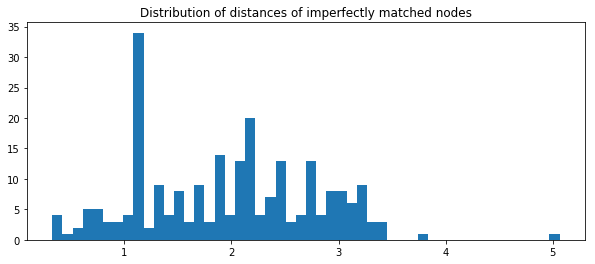

In [23]:
f = plt.figure(figsize=(10, 4))

ax = plt.subplot(1, 1, 1)
ax.set_title('Distribution of distances of imperfectly matched nodes')
n, bins, patches = ax.hist(distances[distances[:,0] != 0][:,0], 50)
# n, bins, patches = ax.hist(distances[:,1], 50, alpha=0.5)